# Correlating two GeoSeries

This notebook performs a small analysis: computing correlation between two GeoSeries.

In [20]:
import json
import requests
import pandas as pd
import io
import ast
import pyleoclim as pyleo

In [2]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse-dynamic' # version this to avoid breaking changes (5?)
url_d = {'{le_var}':'http://linked.earth/ontology/paleo_variables#','{wgs84}':'http://www.w3.org/2003/01/geo/wgs84_pos#','{le}':'http://linked.earth/ontology#','{rdfs}':'http://www.w3.org/2000/01/rdf-schema#'}

In [14]:
query ="""
PREFIX le: <{le}>
PREFIX le_var: <{le_var}>
PREFIX wgs84: <{wgs84}>
PREFIX rdfs: <{rdfs}>

SELECT DISTINCT 
    ?dataSetName ?archiveType ?geo_meanLat ?geo_meanLon ?geo_meanElev 
    ?paleoData_variableName  ?resolution ?paleoData_units ?paleoData_values ?time_values 
    ?paleoData_proxy ?paleoData_proxyGeneral 
    ?time_variableName  ?time_units ?maxTime ?minTime
    ?compilationName ?TSID 
    ?startDate ?endDate 
WHERE {

    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .

    OPTIONAL {
        ?ds le:hasArchiveType ?archiveTypeObj .
        ?archiveTypeObj rdfs:label ?archiveType .
    }

    ?ds le:hasLocation ?loc .
    OPTIONAL {?loc wgs84:lat ?geo_meanLat .}
    OPTIONAL {?loc wgs84:long ?geo_meanLon .}      
    OPTIONAL {?loc wgs84:alt ?geo_meanElev .}

    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .

    ?var le:hasName ?paleoData_variableName .
    ?var le:hasValues ?paleoData_values .
    
    OPTIONAL {
        ?var le:hasUnits ?paleoData_unitsObj .
        ?paleoData_unitsObj rdfs:label ?paleoData_units .
    }
    OPTIONAL {
        ?var le:hasProxy ?paleoData_proxyObj .
        ?paleoData_proxyObj rdfs:label ?paleoData_proxy .
    }
    OPTIONAL {
        ?var le:hasProxyGeneral ?paleoData_proxyGeneralObj .
        ?paleoData_proxyGeneralObj rdfs:label ?paleoData_proxyGeneral .
    }

    ?var le:partOfCompilation ?compilation .
    ?compilation le:hasName ?compilationName .
    VALUES ?compilationName {"Pages2kTemperature"} .

    ?var le:useInGlobalTemperatureAnalysis True .

    OPTIONAL { ?var le:hasVariableId ?TSID }

    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?time_variableName .
    ?timevar le:hasStandardVariable le_var:year .
    ?timevar le:hasValues ?time_values .
    ?timevar le:hasMinValue ?minTime .
    ?timevar le:hasMaxValue ?maxTime .
    OPTIONAL{
        ?timevar le:hasUnits ?time_unitsObj .
        ?time_unitsObj rdfs:label ?time_units .
    }


}
"""

In [15]:
def update_urls(query, url_d):
    for key, value in url_d.items():
        query = query.replace(key, value)
    return query

In [16]:
query = update_urls(query, url_d)


In [17]:
response = requests.post(url, data = {'query': query})

data = io.StringIO(response.text)
df = pd.read_csv(data, sep=",")

In [18]:
df.head()

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,resolution,paleoData_units,paleoData_values,time_values,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_units,maxTime,minTime,compilationName,TSID,startDate,endDate
0,Ant-WDC05A.Steig.2013,Glacier ice,-79.46,-112.09,1806.0,d18O,NaN,permil,"[-33.32873325, -35.6732, -33.1574, -34.2854, -...","[2005, 2004, 2003, 2002, 2001, 2000, 1999, 199...",d18O,NaN,year,yr AD,2005.0,786.0,Pages2kTemperature,Ant_030,NaN,NaN
1,NAm-MtLemon.Briffa.2002,Wood,32.50,-110.80,2700.0,MXD,NaN,NaN,"[0.968, 0.962, 1.013, 0.95, 1.008, 0.952, 1.02...","[1568, 1569, 1570, 1571, 1572, 1573, 1574, 157...",maximum latewood density,NaN,year,yr AD,1983.0,1568.0,Pages2kTemperature,NAm_568,NaN,NaN
2,Arc-Arjeplog.Bjorklund.2014,Wood,66.30,18.20,800.0,density,NaN,NaN,"[-0.829089212152348, -0.733882889924006, -0.89...","[1200, 1201, 1202, 1203, 1204, 1205, 1206, 120...",maximum latewood density,NaN,year,yr AD,2010.0,1200.0,Pages2kTemperature,Arc_060,NaN,NaN
3,Asi-CHIN019.Li.2010,Wood,29.15,99.93,2150.0,trsgi,NaN,NaN,"[1.465, 1.327, 1.202, 0.757, 1.094, 1.006, 1.2...","[1509, 1510, 1511, 1512, 1513, 1514, 1515, 151...",ring width,NaN,year,yr AD,2006.0,1509.0,Pages2kTemperature,Asia_041,NaN,NaN
4,NAm-Landslide.Luckman.2006,Wood,60.20,-138.50,800.0,trsgi,NaN,NaN,"[1.123, 0.841, 0.863, 1.209, 1.139, 1.056, 0.8...","[913, 914, 915, 916, 917, 918, 919, 920, 921, ...",ring width,NaN,year,yr AD,2001.0,913.0,Pages2kTemperature,NAm_1876,NaN,NaN


In [19]:
df['paleoData_values']=df['paleoData_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)
df['time_values']=df['time_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)

In [36]:
import matplotlib.pyplot as plt

def plot_time_coverage(
    df,
    label_col: str = "dataSetName",
    time_col: str = "time_values",
    figsize=(8, None)
):
    """
    Plot a horizontal bar for each row in df showing its time coverage.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
          - df[label_col]: categorical labels
          - df[time_col]: iterable of numeric times
    label_col : str
        Name of the column with category labels.
    time_col : str
        Name of the column with sequence of time values.
    figsize : tuple
        Figure size; if height is None it will be computed from number of rows.
    """
    # Compute starts and ends
    starts = df[time_col].apply(min)
    ends   = df[time_col].apply(max)
    durations = ends - starts

    n = len(df)
    height = figsize[1] or max(1, 0.15 * n)
    fig, ax = plt.subplots(figsize=(figsize[0], height))

    y_pos = range(n)
    ax.barh(y=y_pos, width=durations, left=starts)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df[label_col])
    ax.set_xlabel("Time")
    ax.set_ylabel(label_col)
    ax.set_ylim(min(y_pos) - 0.5, max(y_pos) + 0.5)
    ax.invert_yaxis()  # so the first row is at the top

    plt.tight_layout()
    return fig, ax


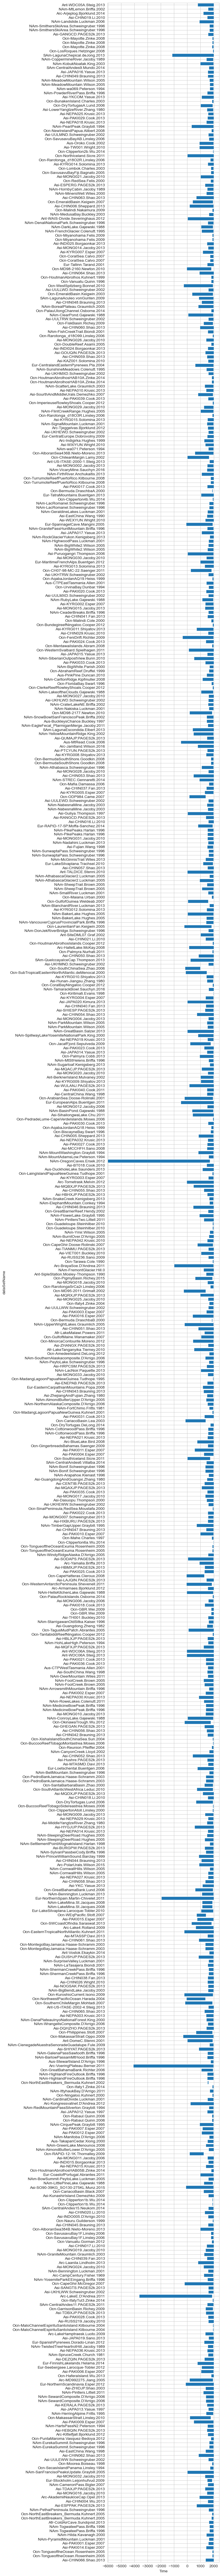

In [37]:
fig, ax = plot_time_coverage(df, label_col='dataSetName', time_col='time_values')

In [21]:
ts_list = []
for _, row in df.iterrows():
    geo_series = pyleo.GeoSeries(time=row['time_values'],value=row['paleoData_values'],
                            time_name=row['time_variableName'],value_name=row['paleoData_variableName'],
                            time_unit=row['time_units'], value_unit=row['paleoData_units'],
                            lat = row['geo_meanLat'], lon = row['geo_meanLon'], 
                            elevation = row['geo_meanElev'],   
                            archiveType = row['archiveType'],
                            observationType=row['paleoData_proxy'],       
                            label=row['dataSetName']+'_'+row['paleoData_proxy'], verbose = False)
    ts_list.append(geo_series)

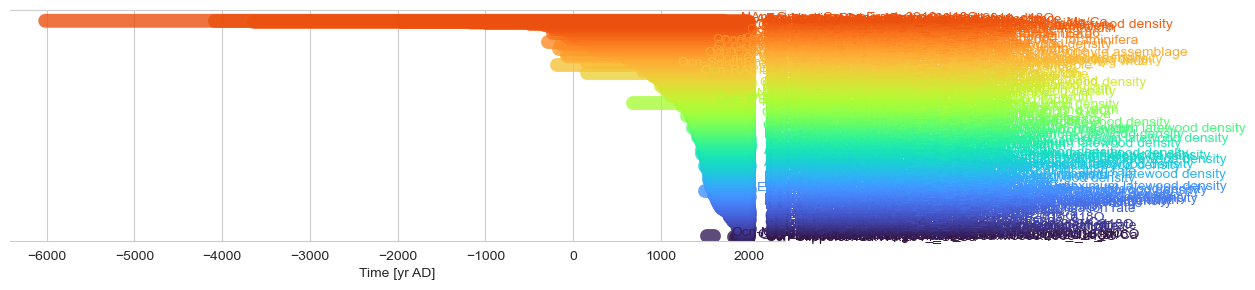

In [52]:
fig, ax = pyleo.MultipleGeoSeries(ts_list).time_coverage_plot(label_y_offset=-.08) #Fiddling with label offsets is sometimes necessary for aesthetic



In [45]:
small_set = [ts_list[0], ts_list[4]]

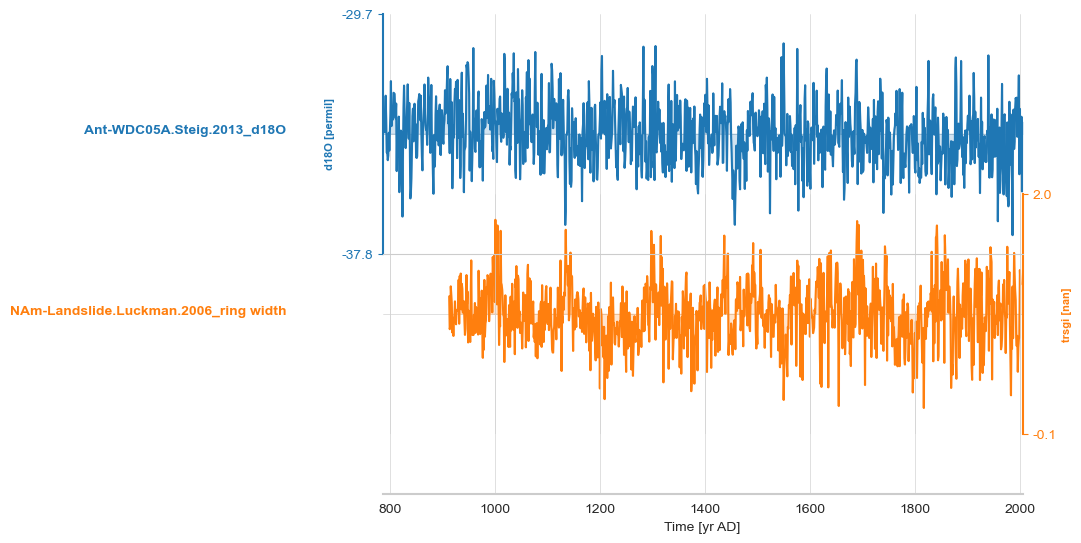

In [48]:
ms = pyleo.MultipleGeoSeries(small_set)
ms.stackplot();

In [49]:
bounds =[max([gs.time.min() for gs in small_set]), 
         min([gs.time.max() for gs in small_set])]

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [yr AD]', ylabel='d18O [permil]'>)

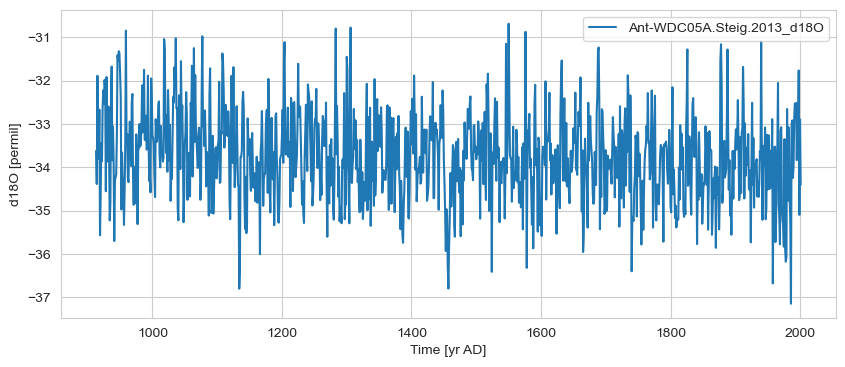

In [50]:
gs1 = ts_list[0].sel(time=slice(bounds[0], bounds[-1]))
# gs1 = gs1.convert_time_unit('ky BP')
gs1.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [yr AD]', ylabel='trsgi [nan]'>)

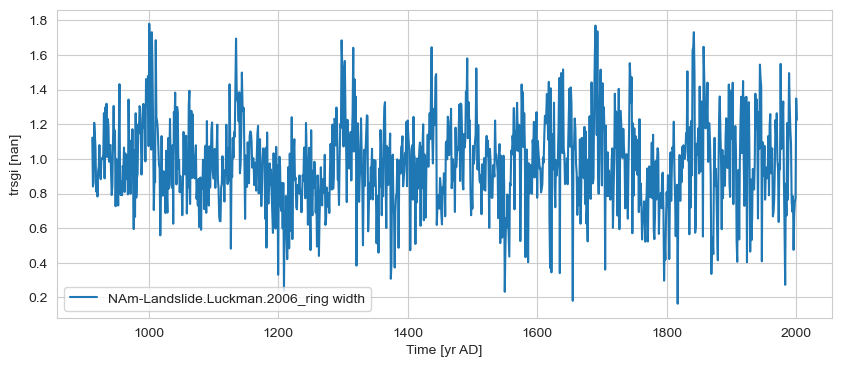

In [51]:
gs2 = ts_list[4].sel(time=slice(bounds[0], bounds[-1]))
# gs2 = gs2.convert_time_unit('ky BP')
gs2.plot()

In [54]:
msc = pyleo.MultipleGeoSeries([gs1, gs2]).common_time()


(<Figure size 1600x600 with 1 Axes>,
 <Axes: xlabel='Time [yr AD]', ylabel='d18O [permil]'>)

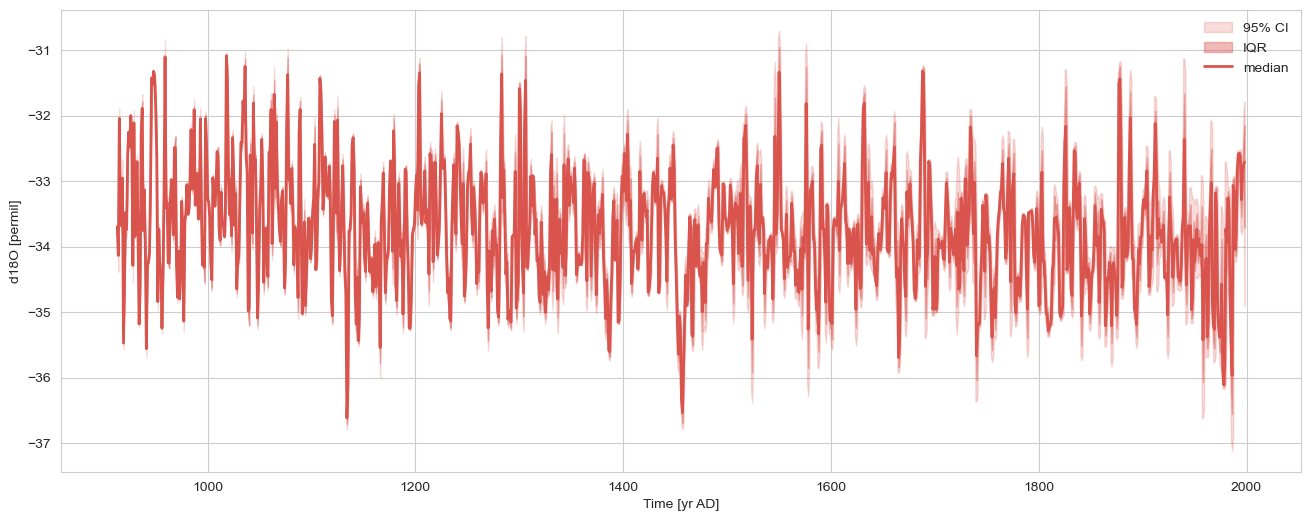

In [59]:
nEns = 1000
n = len(msc.series_list[0].time)
slist = []
for _ in range(nEns):
    pert = pyleo.utils.tsmodel.random_time_axis(n,
                                         delta_t_dist='random_choice',
                                         param =[[-0.1,0,0.1],[0.02,0.96,0.02]])
    ts = msc.series_list[0].copy()
    ts.time = msc.series_list[0].time + pert
    slist.append(ts)
gs1e = pyleo.EnsembleSeries(slist)
gs1e.common_time().plot_envelope(figsize=(16,6))

(<Figure size 1600x600 with 1 Axes>,
 <Axes: xlabel='Time [yr AD]', ylabel='trsgi [nan]'>)

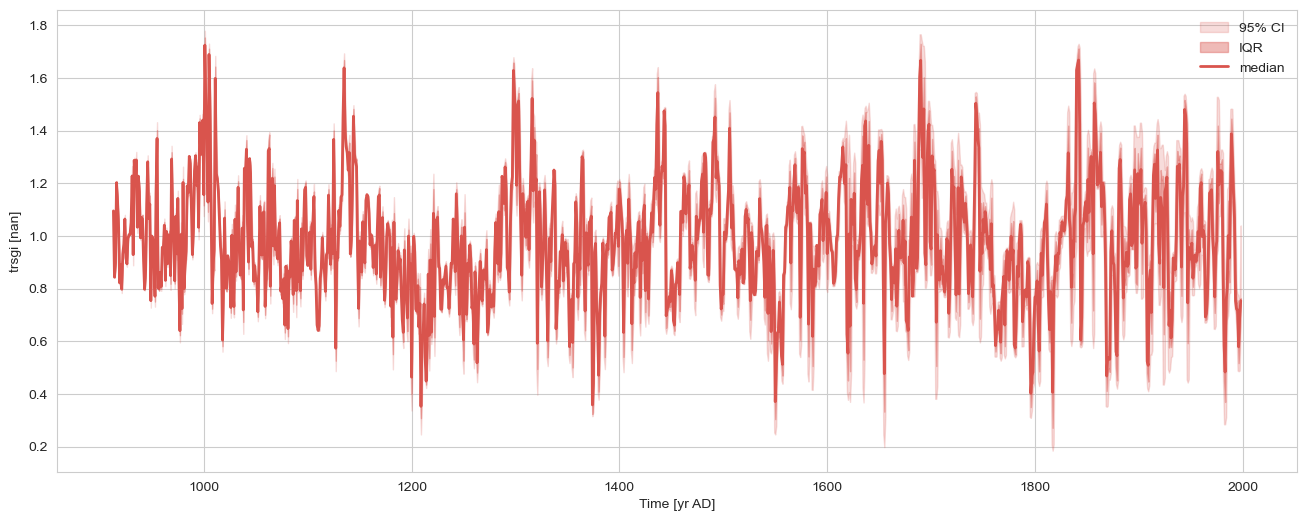

In [60]:
nEns = 1000
n = len(msc.series_list[1].time)
slist = []
for _ in range(nEns):
    pert = pyleo.utils.tsmodel.random_time_axis(n,
                                         delta_t_dist='random_choice',
                                         param =[[-0.1,0,0.1],[0.02,0.96,0.02]])
    ts = msc.series_list[1].copy()
    ts.time = msc.series_list[1].time + pert
    slist.append(ts)
gs2e = pyleo.EnsembleSeries(slist)
gs2e.common_time().plot_envelope(figsize=(16,6))

In [61]:
gs2e_m = gs2e.common_time().quantiles(qs=[0.5]).series_list[0] # this turns it into a Series
gs1e_m = gs1e.common_time().quantiles(qs=[0.5]).series_list[0] # this turns it into a Series
for method in ['built-in','ar1sim','phaseran',]:
    corr_m = gs2e_m.correlation(gs1e_m,method=method)
    print(corr_m)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
   -0.0638035       0.04  True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 14077.96it/s]


  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
   -0.0638035       0.14  False



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 14637.66it/s]

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
   -0.0638035       0.14  False



Looping over 1000 Series in the ensemble


100%|██████████| 1000/1000 [02:36<00:00,  6.40it/s]


AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

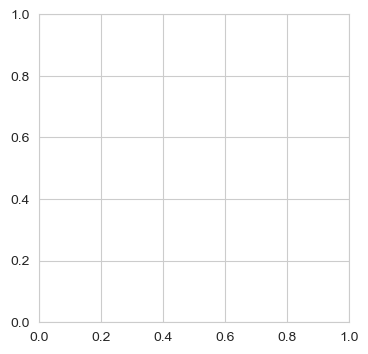

In [62]:
corr_e = gs2e.correlation(gs1e, method='phaseran',number=1000)
corr_e.plot()